In [1]:
import os
import pandas as pd
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from lcmcmc.preprocessing import add_object_band_index, preprocess_SNANA, extract_subsample
from lcmcmc.utils import get_data_dir_path

# Compare classifier ROC curves

In [3]:
from sklearn import metrics

0.9644751746894411
0.9581534549689441


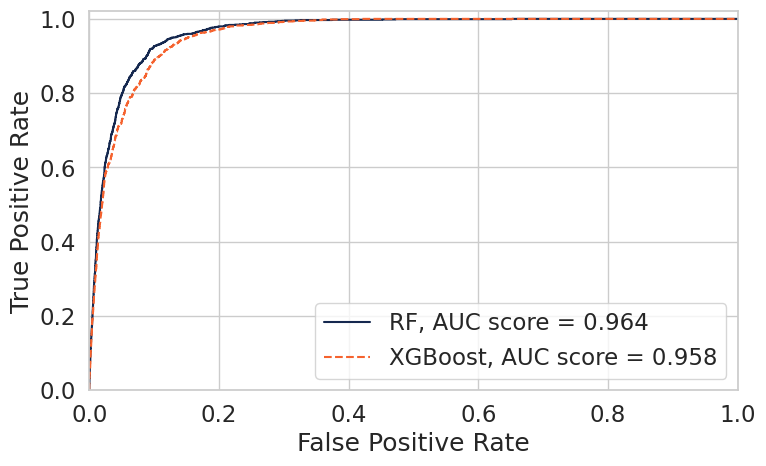

In [4]:
#create ROC curve
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))


colors = ["#15284F", '#F5622E', "#3C8DFF"]
ls = ["-", "--", ":"]

for num, classifier in enumerate(['RF', 'XGBoost']):
    predicted_scores = pd.read_pickle(os.path.join(get_data_dir_path(), f"test_predicted_scores_{classifier}.pkl"))
    
    result = predicted_scores.groupby(['SNID'], as_index=False).agg(
                      {'KNe_prob':['mean','std'],'SNTYPE':'first'})

    result.columns = ["SNID", "KNe_prob_mean", "KNe_prob_std", "SNTYPE"]
    
    auc = metrics.roc_auc_score(y_true=result["SNTYPE"], y_score=result["KNe_prob_mean"])
    print(auc)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=result["SNTYPE"], y_score=result["KNe_prob_mean"])
    plt.plot(fpr,tpr,label=classifier + ", AUC score = {:.3f}".format(auc), color=colors[num], ls=ls[num])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim([0, 1.02])
plt.xlim([0, 1])
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(get_data_dir_path(), "ROC"))
plt.show()

# Load predictions

In [35]:
classifier = "RF"

In [36]:
predicted_scores = pd.read_pickle(os.path.join(get_data_dir_path(), f"test_predicted_scores_{classifier}.pkl"))

result = predicted_scores.groupby(['SNID'], as_index=False).agg(
                      {'KNe_prob':['mean','std'],'SNTYPE':'first'})

result.columns = ["SNID", "KNe_prob_mean", "KNe_prob_std", "SNTYPE"]

In [37]:
predicted_scores

,SNID,KNe_prob,SNTYPE
0,4725641,0.466667,1
1,4725641,0.400000,1
2,4725641,0.466667,1
3,4725641,0.433333,1
4,4725641,0.466667,1
...,...,...,...
42575995,46307633,0.000000,0
42575996,46307633,0.000000,0
42575997,46307633,0.000000,0
42575998,46307633,0.000000,0


In [38]:
result

,SNID,KNe_prob_mean,KNe_prob_std,SNTYPE
0,1612,0.910400,0.047489,1
1,10871,0.000050,0.001290,0
2,10872,0.577169,0.144975,1
3,11422,0.335983,0.050457,0
4,13390,0.023350,0.022731,0
...,...,...,...,...
21283,137049400,0.023833,0.033900,0
21284,137051059,0.121550,0.064139,0
21285,137054088,0.008700,0.018530,0
21286,137071432,0.571467,0.091318,0


In [39]:
tp = (result["KNe_prob_mean"] > 0.5) & (result["SNTYPE"] ==1)
fp = (result["KNe_prob_mean"] > 0.5) & (result["SNTYPE"] !=1)
fn = (result["KNe_prob_mean"] < 0.5) & (result["SNTYPE"] ==1)
tn = (result["KNe_prob_mean"] < 0.5) & (result["SNTYPE"] !=1)

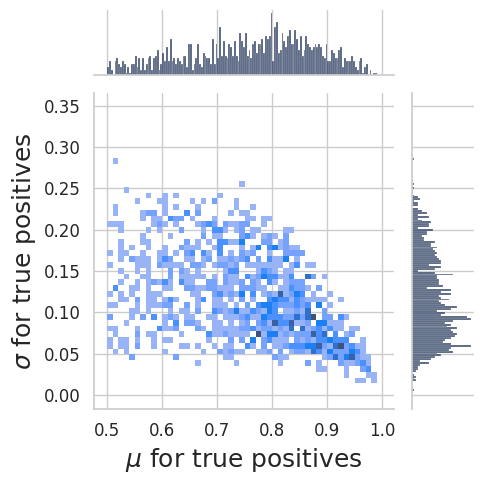

In [40]:
sns.set(font_scale=1.)
sns.set_style("whitegrid")
g = sns.JointGrid(height=5, ratio=4)
x_bins = np.linspace(.5, 1, endpoint=False)
y_bins = np.linspace(0, .35, endpoint=False)
sns.histplot(x=result[tp]["KNe_prob_mean"].values, y=result[tp]["KNe_prob_std"].values, ax=g.ax_joint, bins=[x_bins, y_bins], color="#3C8DFF")
g.ax_joint.set_xlabel("$\mu$ for true positives", fontsize=18)
g.ax_joint.set_ylabel("$\sigma$ for true positives", fontsize=18);

g.ax_joint.tick_params(axis='both', which='major', labelsize=12)

x_bins = np.linspace(.5, 1, endpoint=False, num=150)
y_bins = np.linspace(0, .35, endpoint=False, num=150)

sns.histplot(x=result[tp]["KNe_prob_mean"].values, ax=g.ax_marg_x, bins=x_bins, color="#15284F")
sns.histplot(y=result[tp]["KNe_prob_std"].values, ax=g.ax_marg_y, bins=y_bins, color="#15284F")

plt.tight_layout()

plt.savefig(os.path.join(get_data_dir_path(), "tp.png"))

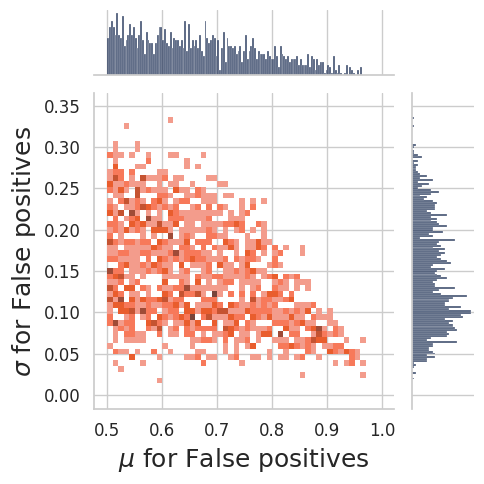

In [41]:
sns.set(font_scale=1.)
sns.set_style("whitegrid")

g = sns.JointGrid(height=5, ratio=4)

x_bins = np.linspace(.5, 1, endpoint=False)
y_bins = np.linspace(0, .35, endpoint=False)

sns.histplot(x=result[fp]["KNe_prob_mean"].values, y=result[fp]["KNe_prob_std"].values, ax=g.ax_joint, bins=[x_bins, y_bins], color='#F5622E')
g.ax_joint.set_xlabel("$\mu$ for False positives", fontsize=18)
g.ax_joint.set_ylabel("$\sigma$ for False positives", fontsize=18);

g.ax_joint.tick_params(axis='both', which='major', labelsize=12)

x_bins = np.linspace(.5, 1, endpoint=False, num=150)
y_bins = np.linspace(0, .35, endpoint=False, num=150)

sns.histplot(x=result[fp]["KNe_prob_mean"].values, ax=g.ax_marg_x, bins=x_bins, color='#15284F')
sns.histplot(y=result[fp]["KNe_prob_std"].values, ax=g.ax_marg_y, bins=y_bins, color='#15284F')

plt.tight_layout()

plt.savefig(os.path.join(get_data_dir_path(), "fp.png"))

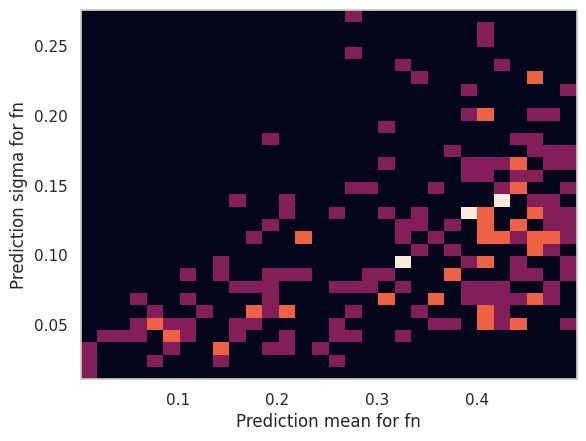

In [42]:
plt.hist2d(result[fn]["KNe_prob_mean"], result[fn]["KNe_prob_std"], bins=30);
plt.xlabel("Prediction mean for fn")
plt.ylabel("Prediction sigma for fn");

Text(0, 0.5, 'arbitrary units')

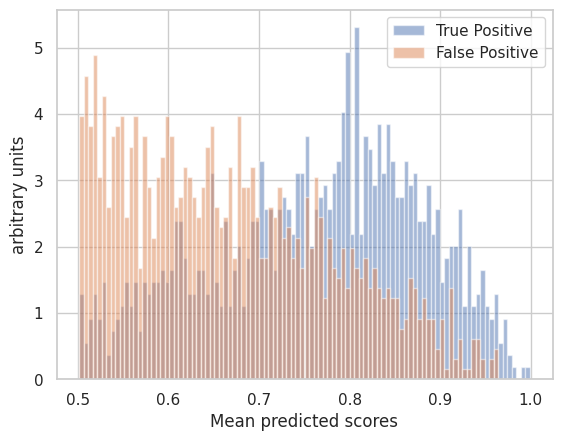

In [13]:
bins = plt.hist(result[tp]["KNe_prob_mean"], bins=100, alpha=.5, density=True, label="True Positive");
plt.hist(result[fp]["KNe_prob_mean"], bins=bins[1], alpha=.5, density=True, label="False Positive");
plt.legend()
plt.xlabel("Mean predicted scores")
plt.ylabel("arbitrary units")

# Scores violin plot

In [14]:

num_events_to_sample = 5

In [15]:
random_state=21
high_scores = result[result["KNe_prob_mean"]>.9]
high_scores = high_scores.sample(num_events_to_sample, random_state=random_state)
low_scores = result[(result["KNe_prob_mean"]>.5) & (result["KNe_prob_mean"]<.6)]
low_scores = low_scores.sample(num_events_to_sample, random_state=random_state)

In [16]:
high_scores

,SNID,KNe_prob_mean,KNe_prob_std,SNTYPE
2360,8899159,0.916600,0.067586,1
3847,15682812,0.912572,0.086885,0
18796,119028810,0.921929,0.051825,0
2233,8360800,0.932233,0.044269,1
2660,10090307,0.950013,0.046855,1


In [17]:
low_scores

,SNID,KNe_prob_mean,KNe_prob_std,SNTYPE
17126,106720253,0.561583,0.116697,0
2369,8935063,0.564048,0.216883,1
110,379764,0.529411,0.220647,0
4410,18344094,0.503072,0.132149,0
13825,83217694,0.526383,0.112228,0


In [18]:
import seaborn as sns

In [19]:
high_scores_plot_df = []
low_scores_plot_df =  []
for sample_num in range(num_events_to_sample):
    current_df_high = {}
    current_df_high["scores"] = predicted_scores["KNe_prob"][predicted_scores["SNID"]==high_scores["SNID"].iloc[sample_num]].values
    current_df_high = pd.DataFrame(current_df_high)
    current_df_high["event number"] = sample_num
    print(high_scores["SNTYPE"].iloc[sample_num])
    print("kn" if high_scores["SNTYPE"].iloc[sample_num] else "non-kn")
    current_df_high["type"] = "kn" if high_scores["SNTYPE"].iloc[sample_num] else "non-kn"
    
    high_scores_plot_df.append(current_df_high)
    
    current_df_low = {}

    current_df_low["scores"] = predicted_scores["KNe_prob"][predicted_scores["SNID"]==low_scores["SNID"].iloc[sample_num]].values
    current_df_low = pd.DataFrame(current_df_low)
    current_df_low["event number"] = sample_num + 5
    current_df_low["type"] = "kn" if low_scores["SNTYPE"].iloc[sample_num] else "non-kn"
    low_scores_plot_df.append(current_df_low)
    
high_scores_plot_df = pd.concat(high_scores_plot_df)
low_scores_plot_df = pd.concat(low_scores_plot_df)

1
kn
0
non-kn
0
non-kn
1
kn
1
kn


In [20]:
high_scores_plot_df

,scores,event number,type
0,0.900000,0,kn
1,0.933333,0,kn
2,1.000000,0,kn
3,0.833333,0,kn
4,0.966667,0,kn
...,...,...,...
1995,0.961417,4,kn
1996,0.932780,4,kn
1997,0.993125,4,kn
1998,0.956436,4,kn


<Axes: xlabel='event number', ylabel='scores'>

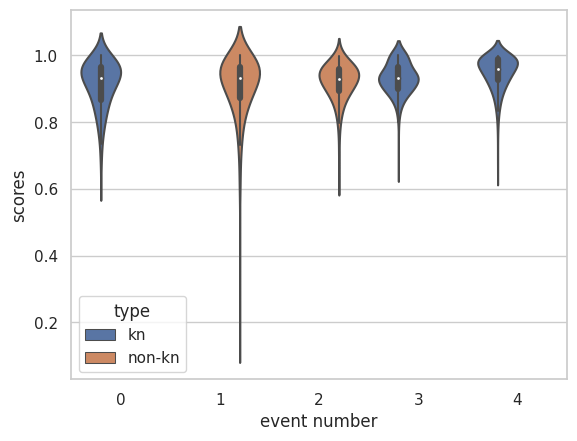

In [21]:
sns.violinplot(data=high_scores_plot_df, x="event number", y="scores", hue="type", bw=.5)

<Axes: xlabel='event number', ylabel='scores'>

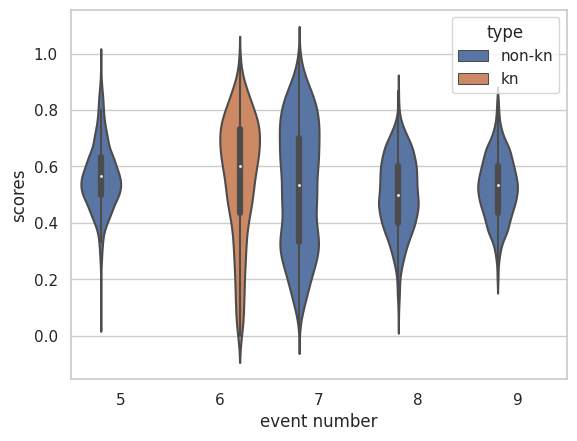

In [22]:
sns.violinplot(data=low_scores_plot_df, x="event number", y="scores", hue="type")

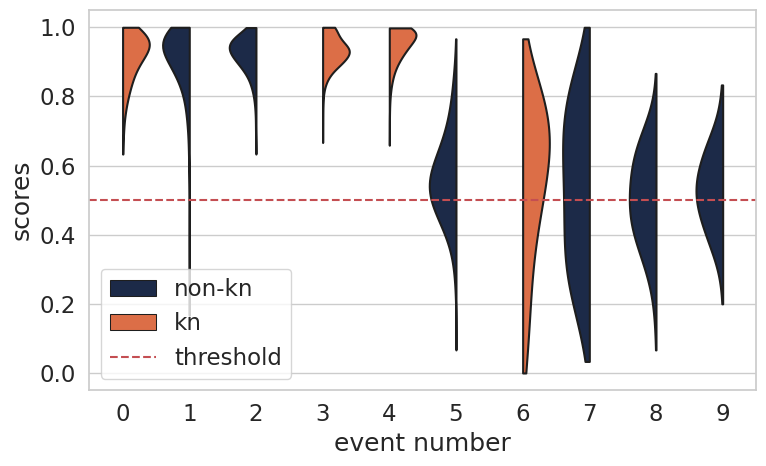

In [23]:
# This plot shows the distribution of scores for 10 events 5 with mean scores > .9 and 5 others with mean score>.5 and <.6

plt.figure(figsize=(8,5))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.violinplot(data=pd.concat((low_scores_plot_df, high_scores_plot_df)), x="event number", y="scores", hue="type", split=True, bw=.5, inner=None, cut=0, palette=["#15284F", '#F5622E'])
plt.axhline(.5, ls="--", color ="r", label="threshold")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(os.path.join(get_data_dir_path(),  "scores distribution"))

# Compute precision and Recall

In [24]:
precision = np.sum(tp)/(np.sum(tp) + np.sum(fp))
print("Precision : {:.2f}".format(precision))

Precision : 0.45


In [25]:
recall = np.sum(tp)/ (np.sum(tp) + np.sum(fn))
print("Recall : {:.2f}".format(recall))

Recall : 0.85
